<a href="https://colab.research.google.com/github/salmanarif86/MLAI/blob/master/hyperparameter_tuning_treebased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('bmh')
sns.set(style="ticks")
plt.rcParams["image.cmap"] = 'viridis'
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import pandas_profiling
from yellowbrick.target import FeatureCorrelation
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,classification_report,log_loss,cohen_kappa_score,roc_auc_score,silhouette_score, silhouette_samples
from sklearn.utils import resample, shuffle
from sklearn import preprocessing
from yellowbrick.classifier import ROCAUC,PrecisionRecallCurve
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


Reading the datafile into a pandas dataframe

In [0]:
df = pd.read_csv('/content/OJ.csv', index_col='Unnamed: 0')

Reading the datafile into a pandas dataframe

In [0]:
df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [0]:
df = df.drop(columns=['PriceDiff','PctDiscMM','PctDiscCH','ListPriceDiff','StoreID'],axis=1)

Transforming the Boolean column 'Store7' to a LabelEncoder. Since it is a Yes/No boolean. 0 and 1 would be an acurate representation of the data

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df['Store7'])


df['Store7'] = le.transform(df['Store7'])

Transforming the Target column to a LabelEncoder. Since it has only 2 classes (MM & CH) - 0 and 1 would be an acurate representation of the data

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df['Purchase'])


df['Purchase'] = le.transform(df['Purchase'])

Defining the Target class and Feature into two seprate dataframes

In [0]:
Y = df[['Purchase']]

In [0]:
X = df[df.columns[1:]]

In [0]:
X.describe()

,WeekofPurchase,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,Store7,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.332710,1.630841
std,15.558286,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.471404,1.430387
min,227.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,0.000000,0.000000
25%,240.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000
50%,257.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.000000,2.000000
75%,268.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,1.000000,3.000000
max,278.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,1.000000,4.000000


Some important characteristics of the dataset 

- There are a total of 1070 indivual instances
- Looking at WeekpfPurchase it starts from 227 until 278 which means a range of 51 covering a period of one year
- The least amount of sales were reported in week of 227 and the most in 274 around 3.6% of the total sales
- Price of Citrus Hill ranges from 1.69 to 2.09 and price of Minute Maid ranges from 1.69 to 2.29
- around 79% of CH were offered no discount while 70% of MM were offered no discount 
-14.8% are special CH and 16.2 are special MM
-Store 0 seems to very popular and sells around 33.3% of the items
-week of purchase shows both spearman and pearson correlation with PriceMM and PriceCH which means its both linear and monotonic

In [0]:
pandas_profiling.ProfileReport(X, check_correlation = False)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,13
Number of observations,1070
Total Missing (%),0.0%
Total size in memory,108.8 KiB
Average record size in memory,104.1 B
Numeric,10
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,0


Clearly the dataset is unbalanced where the majority class is CH and reprsents aroud 61% of the total poulation

In [0]:
pandas_profiling.ProfileReport(Y, check_correlation = False)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,2
Number of observations,1070
Total Missing (%),0.0%
Total size in memory,16.8 KiB
Average record size in memory,16.1 B
Numeric,1
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


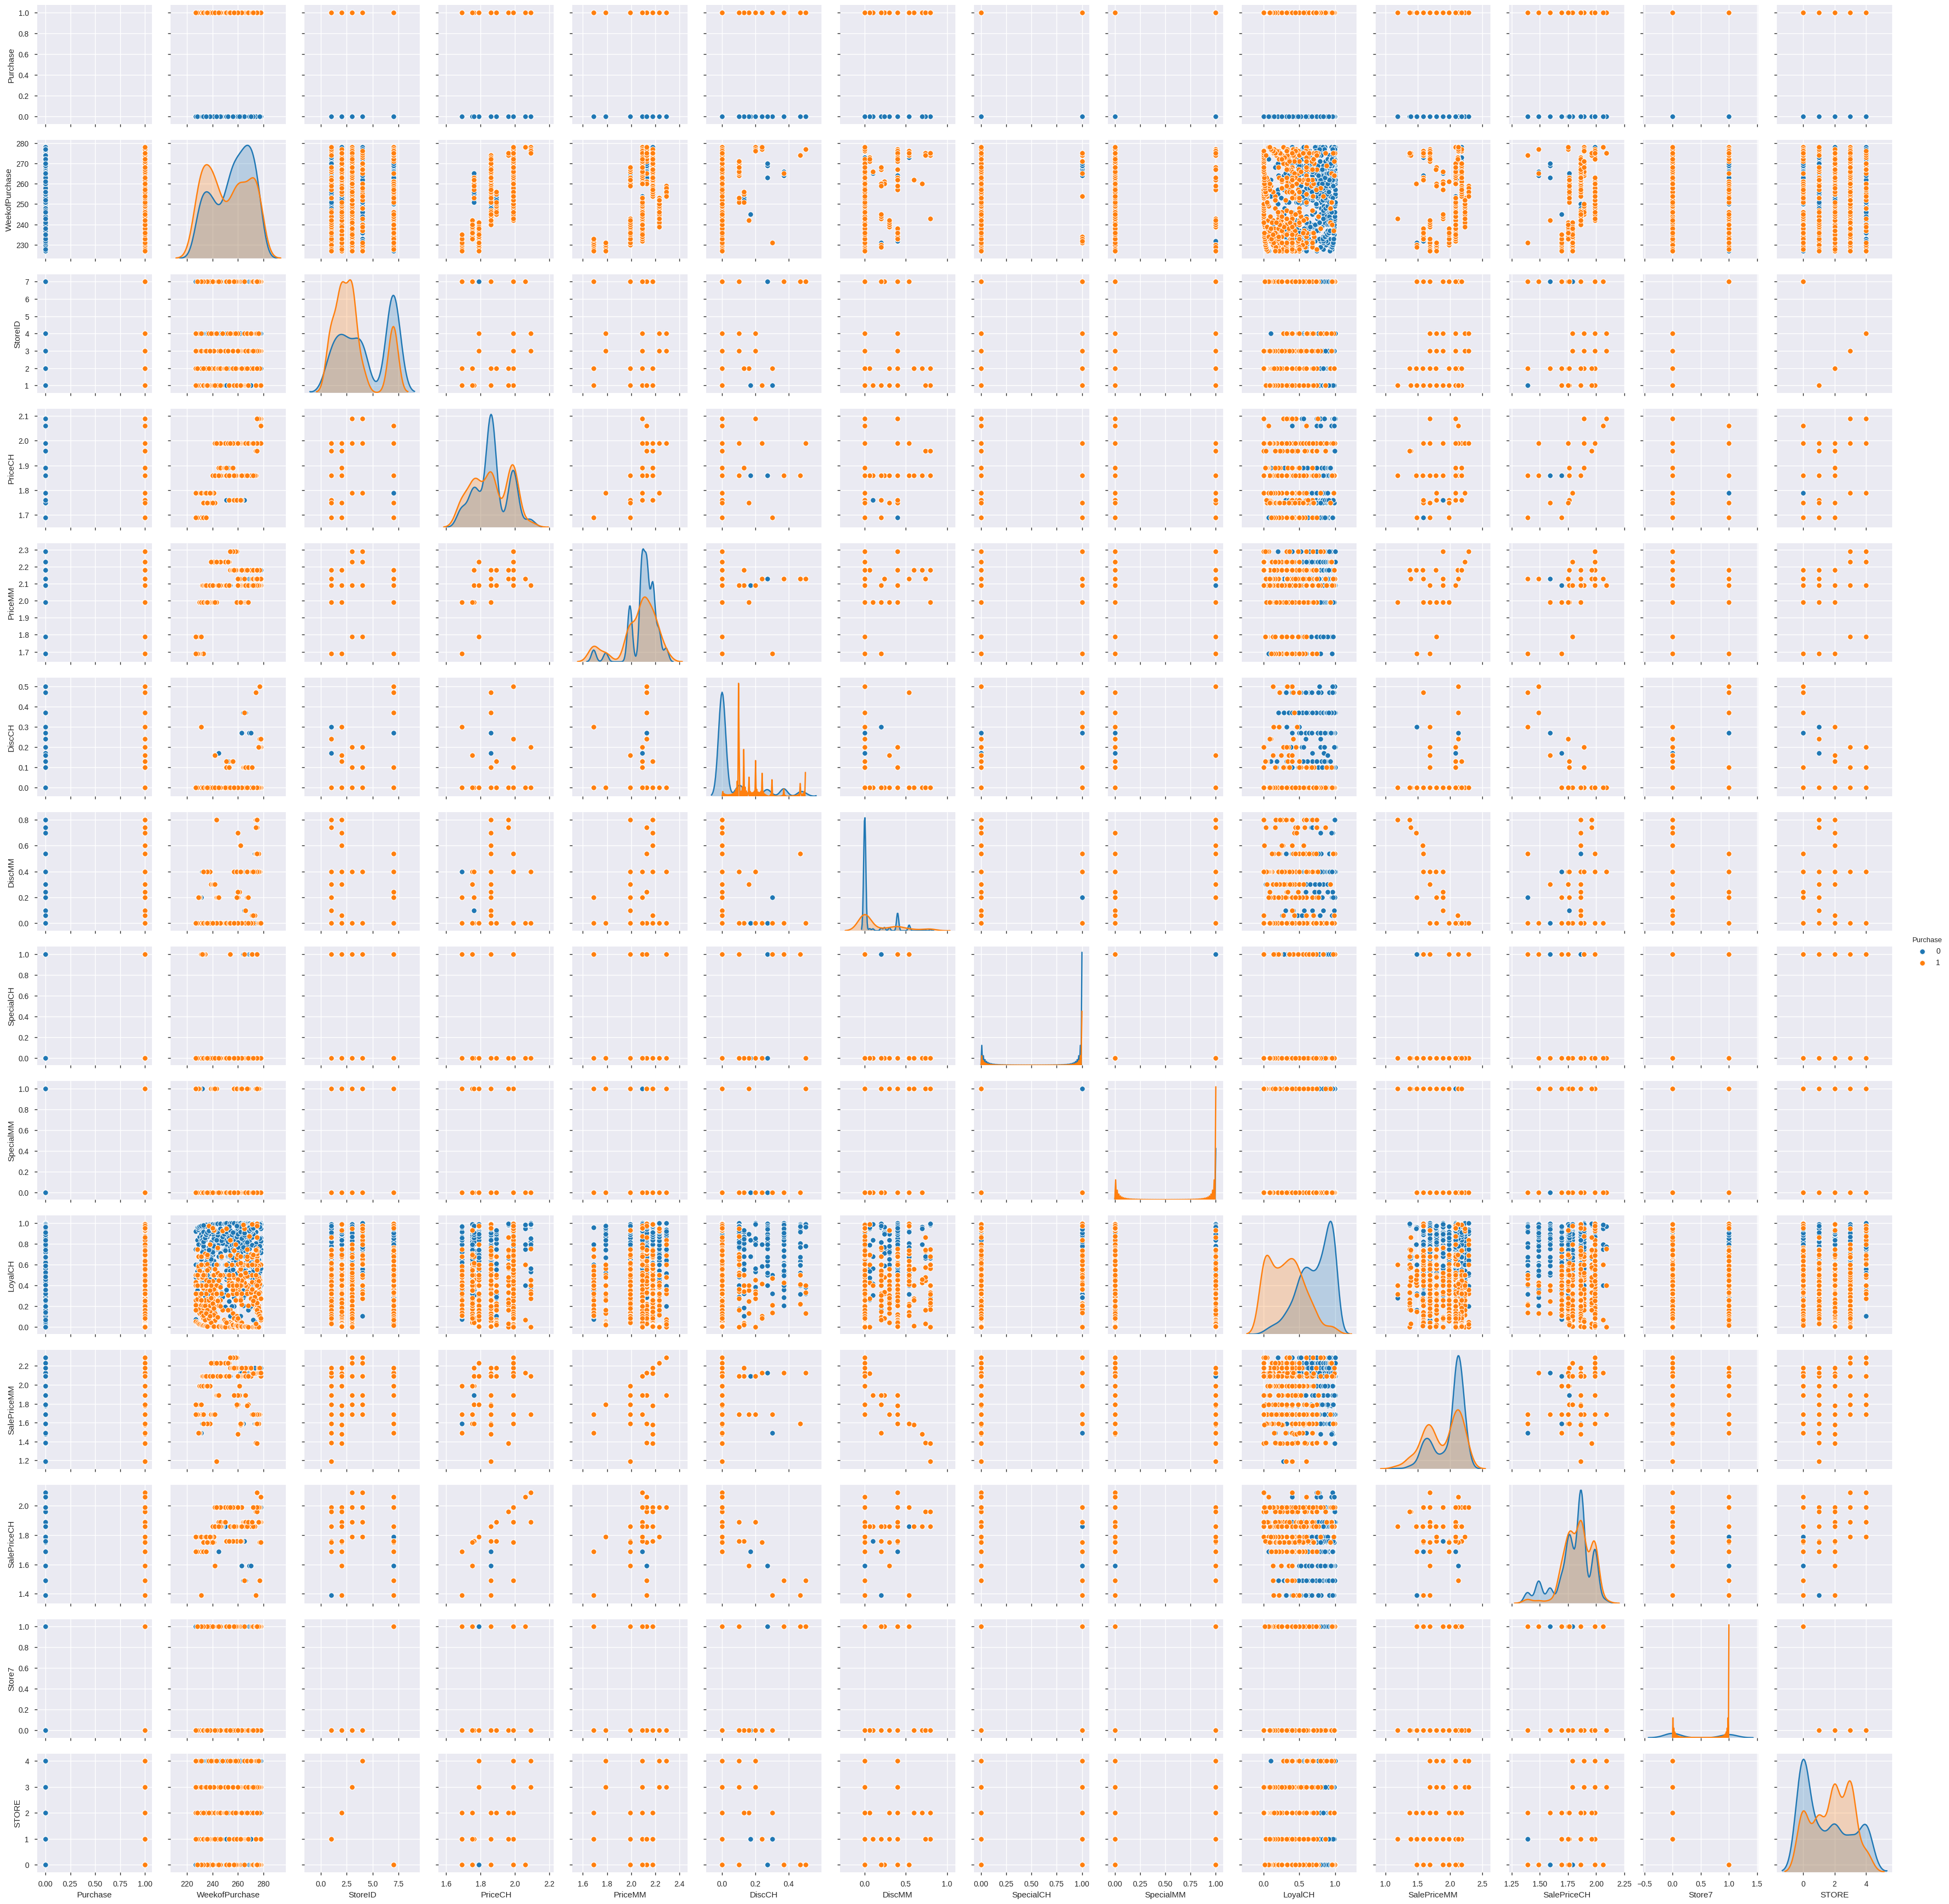

In [0]:
sns.pairplot(df, hue ='Purchase')

Dataset is a bit unbalanced with CH in larger quantity around 61% of the total population. However at first I am going to use stratfied shuffle split to keep the data distribution between train and test set the same as we split it to get ready for training our model

In [0]:
ax = sns.catplot(x="Purchase", kind="count", palette="ch:.25", data=df,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df, df['Purchase']):
  strat_train = df.iloc[train_index]
  strat_test  = df.iloc[test_index]

The distribution of train/test split is now identical as shown below

**Train Set**

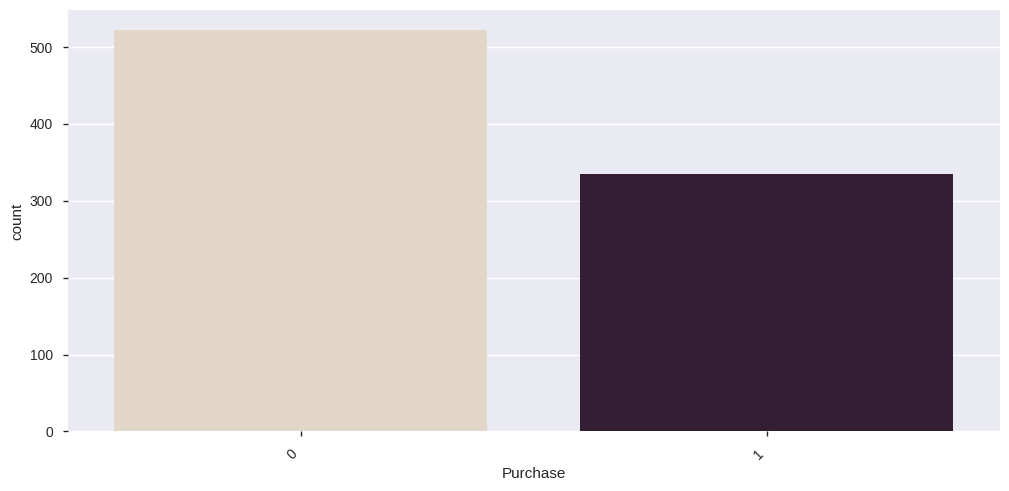

In [0]:
ax = sns.catplot(x="Purchase", kind="count", palette="ch:.25", data=strat_train,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')


**Test Set**

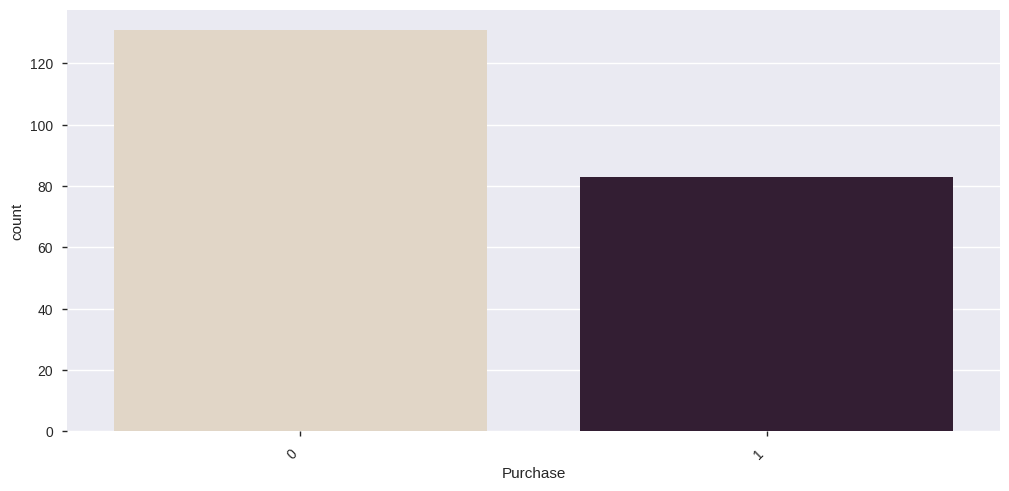

In [0]:
ax = sns.catplot(x="Purchase", kind="count", palette="ch:.25", data=strat_test,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

splitting the data set into test/train. Also extracting the target column out for training the model

In [0]:
X_train =strat_train[strat_train.columns[1:]]

In [0]:
Y_train = strat_train[['Purchase']]

In [0]:
X_test =strat_test[strat_test.columns[1:]]

In [0]:
Y_test = strat_test[['Purchase']]


**DecisionTrees**

In [0]:
clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=5, max_leaf_nodes=5)
clf.fit(X_train, Y_train)

Y_pred_dt = clf.predict(X_test)

**Model Performance**

In [0]:
print(confusion_matrix(Y_test, Y_pred_dt))

[[111  20]
 [ 29  54]]


In [0]:
print(classification_report(Y_test,Y_pred_dt))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       131
           1       0.73      0.65      0.69        83

    accuracy                           0.77       214
   macro avg       0.76      0.75      0.75       214
weighted avg       0.77      0.77      0.77       214



In [0]:
print("Kappa = {:.2f}".format(cohen_kappa_score(Y_test, Y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(Y_test, Y_pred_dt)))


Kappa = 0.51
Log Loss = 7.91


**ROC Curve**

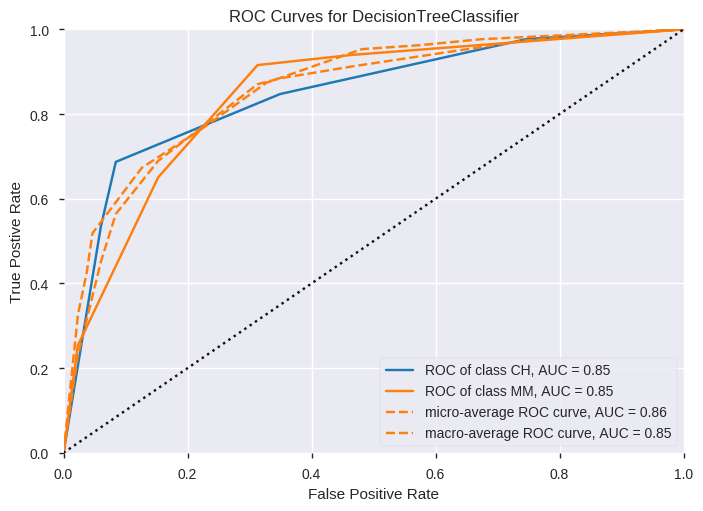

In [0]:
visualizer = ROCAUC(clf, classes=['CH','MM'])

visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)  
g = visualizer.poof()           

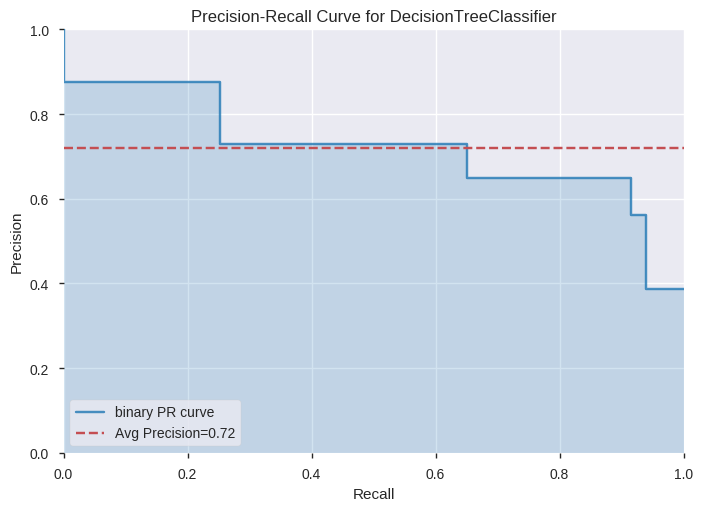

In [0]:
viz = PrecisionRecallCurve(clf);
viz.fit(X_train, Y_train);
viz.score(X_test, Y_test);
viz.poof();

**Random Forest**

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=500,max_depth=3,n_jobs=-1,random_state=15,criterion='entropy')

In [0]:
rnd_clf.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
Y_pred_fr = rnd_clf.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, Y_pred_fr))

[[116  15]
 [ 28  55]]


In [0]:
print(classification_report(Y_test,Y_pred_fr))

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.79      0.66      0.72        83

    accuracy                           0.80       214
   macro avg       0.80      0.77      0.78       214
weighted avg       0.80      0.80      0.80       214



In [0]:
df_majority = strat_train[strat_train['Purchase']== 0]
df_minority = strat_train[strat_train['Purchase']== 1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

In [0]:
strat_train =pd.concat([df_majority_downsampled,df_minority])
strat_train = shuffle(strat_train)

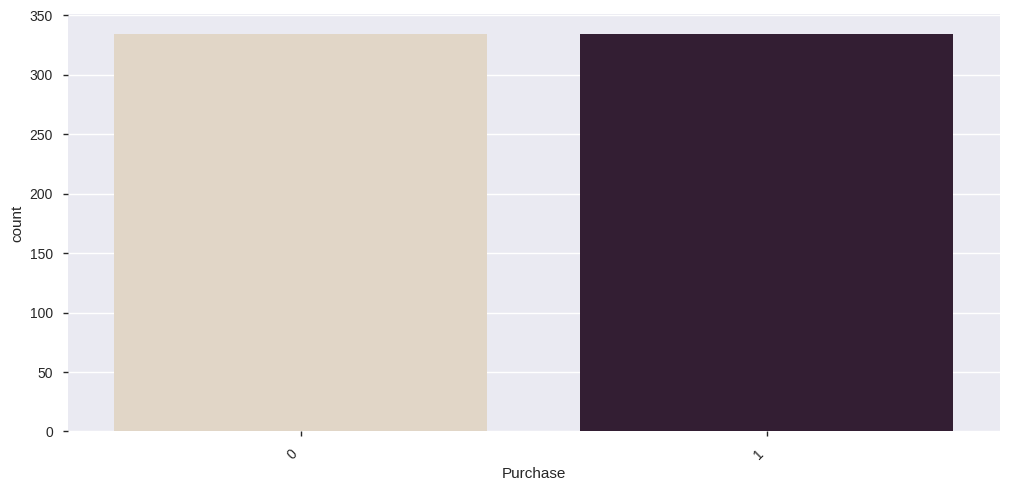

In [0]:
ax = sns.catplot(x="Purchase", kind="count", palette="ch:.25", data=strat_train,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

In [0]:
X_train =strat_train[strat_train.columns[1:]]
Y_train = strat_train[['Purchase']]
X_test =strat_test[strat_test.columns[1:]]
Y_test = strat_test[['Purchase']]


In [0]:
rnd_clf = RandomForestClassifier(n_estimators=500,max_depth=5,n_jobs=-1,random_state=15,criterion='entropy')
rnd_clf.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
Y_pred_fr = rnd_clf.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, Y_pred_fr))

[[107  24]
 [ 11  72]]


In [0]:
print(classification_report(Y_test,Y_pred_fr))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       131
           1       0.75      0.87      0.80        83

    accuracy                           0.84       214
   macro avg       0.83      0.84      0.83       214
weighted avg       0.85      0.84      0.84       214



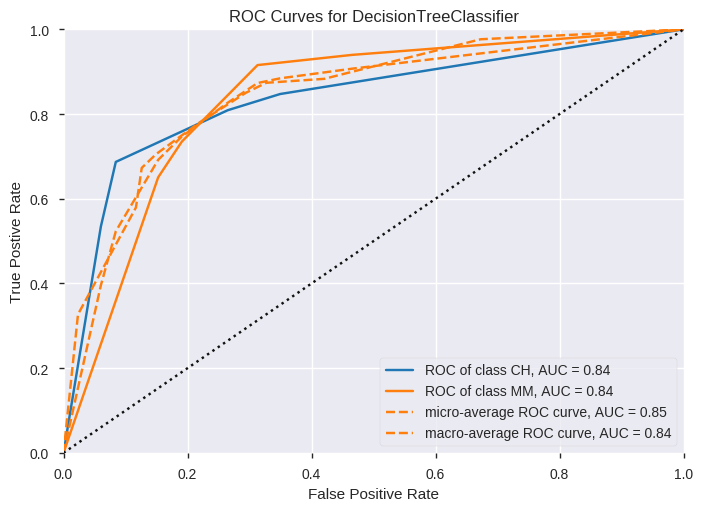

In [0]:
visualizer = ROCAUC(clf, classes=['CH','MM'])

visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)  
g = visualizer.poof()     

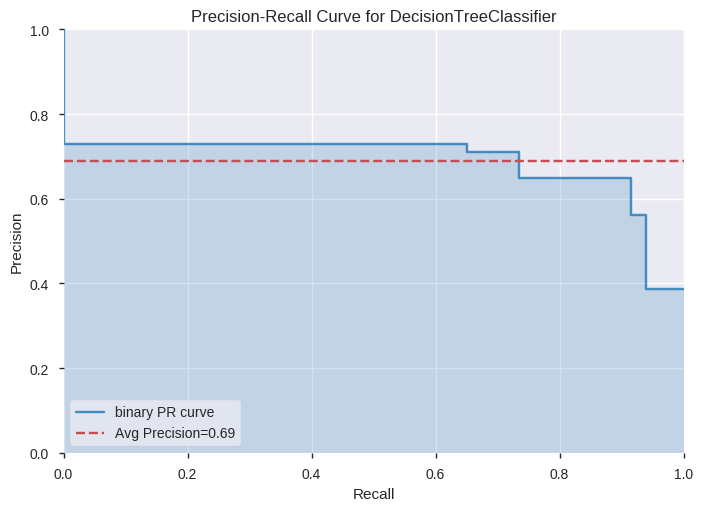

In [0]:
viz = PrecisionRecallCurve(clf);
viz.fit(X_train, Y_train);
viz.score(X_test, Y_test);
viz.poof();

**HYPERPARAMETER TUNING**

**(i) Random Search Training**

Since random forest has a large number of hyperparameters to tune, the most efficient way is to try a large number of values and see what works. The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = [2,4,6,8,10,12]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 30, num = 15)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, None],
 'max_features': [2, 4, 6, 8, 10, 12],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [0]:
rnd_clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rnd_clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, Y_train)

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 16,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 466}

In [0]:
rnd_clf = RandomForestClassifier(bootstrap= True, max_depth = 16, max_features = 4, min_samples_leaf = 4, min_samples_split = 5, n_estimators = 466)

In [0]:
rnd_clf.fit(X_train, Y_train)

In [0]:
Y_pred_fr = rnd_clf.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, Y_pred_fr))

In [0]:
print(classification_report(Y_test,Y_pred_fr))

**(ii) Grid Search with Cross Validation**

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [14, 15, 16, 17],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [466, 566, 366, 666] }

In [0]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [0]:
grid_search.fit(X_train, Y_train)

In [0]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 16,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 566}

In [0]:
rf = RandomForestClassifier(bootstrap= True, max_depth = 16, max_features = 3, min_samples_leaf = 5, min_samples_split = 6, n_estimators = 566)

In [0]:
rf.fit(X_train, Y_train)

In [0]:
Y_pred_fr = rf.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, Y_pred_fr))

[[106  25]
 [ 11  72]]


In [0]:
print(classification_report(Y_test,Y_pred_fr))

              precision    recall  f1-score   support

           0       0.91      0.81      0.85       131
           1       0.74      0.87      0.80        83

    accuracy                           0.83       214
   macro avg       0.82      0.84      0.83       214
weighted avg       0.84      0.83      0.83       214



**Gaussian Naive Bayes**

We will apply Bayesian inference on Santander Customer Transaction data, which has a binary target and 12 continuous features. We model the target as unknown  Y  and the features as observation  X . The prior  pY(y)  reflects our knowledge about the unknown before observation. In this problem,  Y  is Bernoulli (only two classes) so it can be specified by setting the positive probability, which is usually set as the proportion of the positive class in the data. The likelihood  fX|Y(x|y)  models the distribution of the observation given that we know the class. The posterior  pY|X(y|x)  is our updated knowledge about the unknown after observation.

The MAP (Maximum A Posteriori) estimator picks the class with the highest posterior probability. For binary classification, it has the same effect as setting a threshold of  0.5  for the positive posterior probability. The LMS (Least Mean Squares) estimator  E[Y|X]  picks the mean of the posterior distribution. For binary classification, this is just the positive posterior probability  pY|X(1|x)

Note that we only require 1 number for the prior and 48 numbers for the likelihood (12 sample means and variances for each of the two classes). "Fitting" is just computing those numbers, and "predicting" is carried out according to the above formula (although we need to operate on the log scale because multiplying many small numbers poses a problem when our machine has limited precision). It is a very simple and efficient model.

We will look at the likelihood distributions by plotting the KDE (Kernel Density Estimates) 

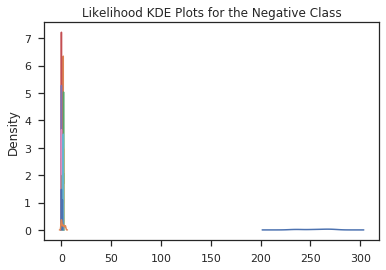

In [0]:
pd.DataFrame(X_train[Y_train.values == 0]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class');

Text(0.5, 1.0, 'Likelihood KDE Plots for the Positive Class')

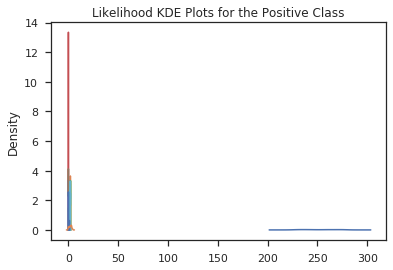

In [0]:
pd.DataFrame(X_train[Y_train.values == 1]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class')

The KDE plots above suggest that the likelihood distributions have different centers and spread. We will standardize them (subtract mean and divide by standard deviation) so that they have zero mean and unit variance. We can use sklearn.preprocessing.StandardScaler for standardization.

In [0]:
scaled = pd.DataFrame(StandardScaler().fit_transform(X_train))

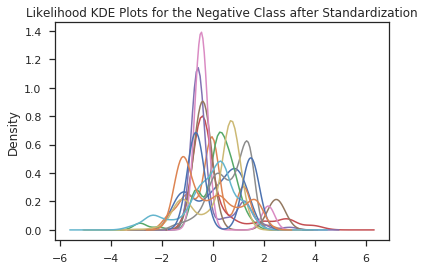

In [0]:
scaled[Y_train.values == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization');

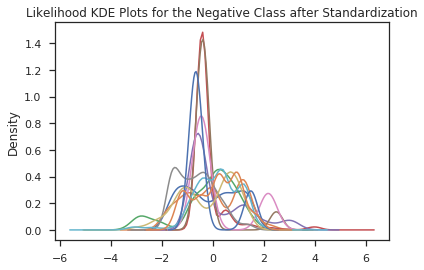

In [0]:
scaled[Y_train.values == 1].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization');

In [0]:
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(X_train))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (668). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


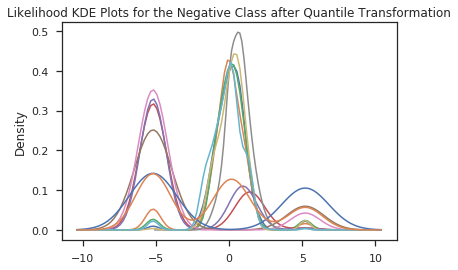

In [0]:
transformed[Y_train.values == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Quantile Transformation');

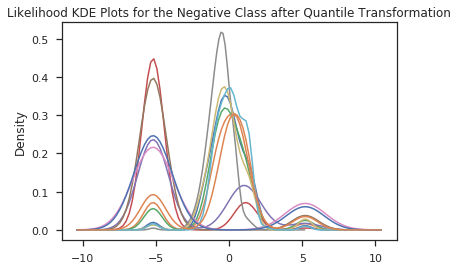

In [0]:
transformed[Y_train.values == 1].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Quantile Transformation');

In the KDE plots above, the likelihood distributions have become normal as we desire.

Independence is difficult to check, but we can check the sample correlation coefficients. Small correlation coefficients mean that there is a weak linear pattern.

In [0]:
corr = transformed.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,0.64,0.43,0.31,0.16,0.019,0.021,0.14,0.094,0.29,0.064,-0.062
1,0.64,1,0.64,0.25,0.1,-0.12,-0.064,0.021,0.23,0.57,-0.1,0.22
2,0.43,0.64,1,-0.0082,-0.067,-0.045,-0.036,0.034,0.63,0.43,-0.039,0.13
3,0.31,0.25,-0.0082,1,-0.14,0.38,-0.098,0.08,0.009,-0.39,0.19,-0.099
4,0.16,0.1,-0.067,-0.14,1,0.082,0.48,0.0063,-0.64,0.045,0.075,-0.11
5,0.019,-0.12,-0.045,0.38,0.082,1,-0.15,0.14,-0.068,-0.46,0.4,-0.35
6,0.021,-0.064,-0.036,-0.098,0.48,-0.15,1,-0.038,-0.38,0.0051,-0.08,-0.011
7,0.14,0.021,0.034,0.08,0.0063,0.14,-0.038,1,-0.025,-0.066,0.23,-0.063
8,0.094,0.23,0.63,0.009,-0.64,-0.068,-0.38,-0.025,1,0.24,-0.089,0.16
9,0.29,0.57,0.43,-0.39,0.045,-0.46,0.0051,-0.066,0.24,1,-0.33,0.4


The further away the centers of the distributions or the greater the difference in the spread of the distributions, the more it can tell about which class the point is coming from.

If there are features  Xi  such that the likelihood distributions are equal —  fXi|Y(xi|0)=fXi|Y(xi|1) , their densities will cancel in the numerator and the denominator. These features do not help in classification. So, in some sense, the Bayes classifier performs automatic feature selection.

Text(0.5, 1.0, 'Histogram of Sample Mean Differences between Two Classes')

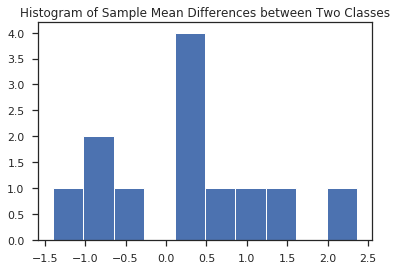

In [0]:
plt.hist(transformed[Y_train.values == 0].mean() - transformed[Y_train.values == 1].mean())
plt.title('Histogram of Sample Mean Differences between Two Classes')

Text(0.5, 1.0, 'Histogram of Sample Variances Differences between Two Classes')

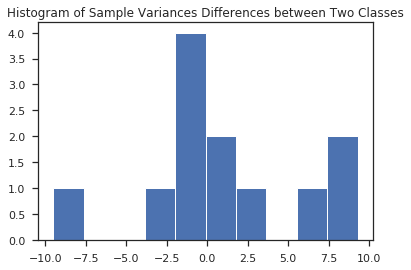

In [0]:
plt.hist(transformed[Y_train.values == 0].var() - transformed[Y_train.values == 1].var())
plt.title('Histogram of Sample Variances Differences between Two Classes')

In [0]:
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (668). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

After training the model, we plot the ROC curve on training data and evaluate the model by computing the training AUC and cross-validation AUC. We can use sklearn.metrics.roc_curve to obtain the values for plotting the curve and sklearn.metrics.auc for computing the AUC.

0.824169027215031

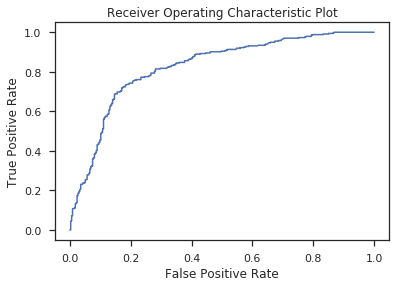

In [0]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(Y_train, pipeline.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

We compute the 10-fold cross-validation score by using sklearn.model_selection.cross_val_score.

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline, X_train, Y_train, scoring='roc_auc', cv=10).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (600). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (600). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/d

0.813425184528519

We achieved good AUC on both training and cross-validation. But is this the best that this model can achieve? Let us use simulation to get an estimate of the optimal AUC that this model can achieve. We will draw samples from the normal distribution with the 48 parameters of the likelihood. The amount of samples to draw from each class will be determined by the prior so that the classes have the same proportions as the training data.

In [0]:
from sklearn.metrics import roc_auc_score

pipeline.fit(X_train, Y_train)
model = pipeline.named_steps['gaussiannb']
size = 1000000
size0 = int(size * model.class_prior_[0])
size1 = size - size0
sample0 = np.concatenate([[np.random.normal(i, j, size=size0)]
                          for i, j in zip(model.theta_[0], np.sqrt(model.sigma_[0]))]).T
sample1 = np.concatenate([[np.random.normal(i, j, size=size1)]
                          for i, j in zip(model.theta_[1], np.sqrt(model.sigma_[1]))]).T
X_sample = np.concatenate([sample0, sample1])
y_sample = np.concatenate([np.zeros(size0), np.ones(size1)])
roc_auc_score(y_sample, model.predict_proba(X_sample)[:,1])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (668). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9371448628959999

There is quite a bit of difference in roc_auc between the data generated by independent normal distribution.  This is possibly because the normality and independent assumption is probably not entierly true for our dataset.

**Gradient Boosting Trees**

Lets define a function which will help us create GBM models and perform cross-validation.

In [0]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], Y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], Y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : (%.4g)" % accuracy_score(Y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(Y_train.values, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Lets start by creating a baseline model. In this case, the evaluation metric is AUC so using any constant value will give 0.5 as result. Typically, a good baseline can be a GBM model with default parameters, i.e. without any tuning. Lets find out what it gives:

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


Model Report
Accuracy : (0.8922)
AUC Score (Train): 0.969679
CV Score : Mean - 0.8768387 | Std - 0.02480866 | Min - 0.8455112 | Max - 0.9183884


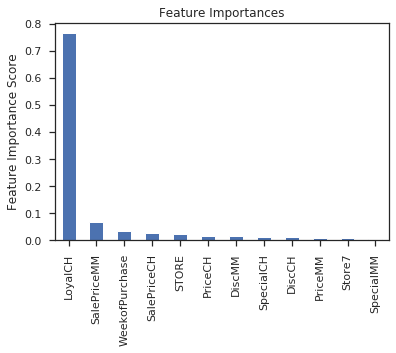

In [0]:
predictors = [x for x in X_train.columns]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, predictors);

So, the mean CV score is 0.876 and we should expect our model to do better than this.

**Hyperparameter Tuning**

There are two types of parameter to be tuned here – tree based and boosting parameters. There are no optimum values for learning rate as low values always work better, given that we train on sufficient number of trees.

Though, GBM is robust enough to not overfit with increasing trees, but a high number for pa particular learning rate can lead to overfitting. But as we reduce the learning rate and increase trees, the computation becomes expensive and would take a long time to run on standard personal computers.

Keeping all this in mind, we can take the following approach:

Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
Lower the learning rate and increase the estimators proportionally to get more robust models.

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

In [0]:
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':range(100,200,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, min_samples_split=7,min_samples_leaf=1,max_depth=3,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=7,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  preso

In [0]:
gsearch1.cv_results_, gsearch1.best_score_,gsearch1.best_params_

({'mean_fit_time': array([0.32213211, 0.34456415, 0.37686582, 0.42234874, 0.43823667,
         0.46507878, 0.49817624, 0.53383279, 0.55382371, 0.51592736]),
  'mean_score_time': array([0.01394734, 0.01366653, 0.01628938, 0.01166162, 0.01398735,
         0.01456895, 0.01263075, 0.01556726, 0.01617813, 0.01017456]),
  'mean_test_score': array([0.88716696, 0.88595994, 0.88578852, 0.88462061, 0.88513434,
         0.88571217, 0.88455242, 0.88486566, 0.88442829, 0.88447692]),
  'param_n_estimators': masked_array(data=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 100},
   {'n_estimators': 110},
   {'n_estimators': 120},
   {'n_estimators': 130},
   {'n_estimators': 140},
   {'n_estimators': 150},
   {'n_estimators': 160},
   {'n_estimators': 170},
   {'n_estimators': 180},
   {'n_estimators': 

**1. Tuning tree-specific parameters**


Now lets move onto tuning the tree parameters. I plan to do this in following stages:

1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features

The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

To start with, I’ll test max_depth values of 2 to 15 in steps of 2 and min_samples_split from 5 to 50 in steps of 5. These are just based on my intuition. You can set wider ranges as well and then perform multiple iterations for smaller ranges.

In [0]:
param_test2 = {'max_depth':range(1,15,1), 'min_samples_split':range(5,50,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'max_depth': 2, 'min_samples_split': 30}, 0.8904526798596141)

When you compare to our baseline we were able to squeeze an extra 2% AUC for cv score. If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


Model Report
Accuracy : (0.8473)
AUC Score (Train): 0.922676
CV Score : Mean - 0.8904527 | Std - 0.02458935 | Min - 0.8694587 | Max - 0.9376722


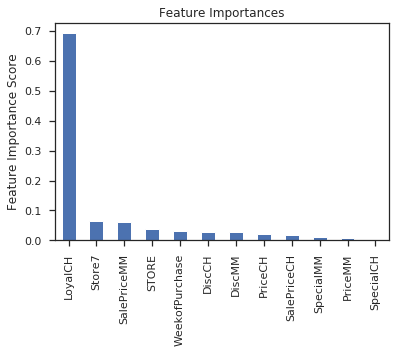

In [0]:
modelfit(gsearch2.best_estimator_, X_train, predictors)

Now lets tune the last tree-parameters, i.e. max_features by trying 10 values from 2 to 12

In [0]:
#param_test_3 forgot to perform this ...check notes and redo

In [0]:
param_test4 = {'max_features':range(2,13,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=2, min_samples_split=30, min_samples_leaf=1, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'max_features': 3}, 0.8904526798596141)

Here, we find that optimum value is 12, which is also the square root. So our initial value was the best. 

min_samples_split: 30
min_samples_leaf: 1
max_depth: 9
max_features: 7

**XGBoost**

**1.Regularization:**
Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting. In fact, XGBoost is also known as a‘regularized boosting‘ technique.

**2.Parallel Processing:**
XGBoost implements parallel processing and is blazingly faster as compared to GBM. XGBoost also supports implementation on Hadoop.

**3. High Flexibility**
XGBoost allows users to define custom optimization objectives and evaluation criteria. This adds a whole new dimension to the model and there is no limit to what we can do.

**4.Handling Missing Values**
XGBoost has an in-built routine to handle missing values. The user is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.

**5.Tree Pruning:**
A GBM would stop splitting a node when it encounters a negative loss in the 
split. Thus it is more of a greedy algorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain. 
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.

**6.Built-in Cross-Validation**
XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
This is unlike GBM where we have to run a grid-search and only a limited values can be tested.


**7.Continue on Existing Model**
User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
GBM implementation of sklearn also has this feature so they are even on this point.


**XGBoost Parameters**

The overall parameters have been divided into 3 categories by XGBoost authors


1.   **General Parameters:** Guide the overall functioning
2.   **Booster Parameters:** Guide the individual booster (tree/regression) at each step
3. **Learning Task Parameters:** Guide the optimization performed


**General Parameters**

These define the overall functionality of XGBoost.
** 1. booster [default=gbtree]**

      Select the type of model to run at each iteration. It has 2 options:
      gbtree: tree-based models

*   gbtree: tree-based models
*   gblinear: linear models


**2.  silent [default=0]:**
*    Silent mode is activated is set to 1, i.e. no running messages will be printed.
*   It’s generally good to keep it 0 as the messages might help in understanding the model.

**3.nthread [default to maximum number of threads available if not set]**

* This is used for parallel processing and number of cores in the system should be entered

* If you wish to run on all cores, value should not be entered and algorithm will detect automatically





**Booster Parameters**
Though there are 2 types of boosters, I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

**1. eta [default=0.3]**
* Analogous to learning rate in GBM
* Makes the model more robust by shrinking the weights on each step
* Typical final values to be used: 0.01-0.2

**2. min_child_weight [default=1]**
* Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. 
* Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
* Too high values can lead to under-fitting hence, it should be tuned using CV.

**3. max_depth [default=6]**
* The maximum depth of a tree, same as GBM.
* Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.Should be tuned using CV.
* Typical values: 3-10

**4. max_leaf_nodes**
* The maximum number of terminal nodes or leaves in a tree.
* Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
* If this is defined, GBM will ignore max_depth.

**5. gamma [default=0]**
* A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
* Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

**6. max_delta_step [default=0]**
* In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
* This is generally not used but you can explore further if you wish.

**7. subsample [default=1]**
* Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
* Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
* Typical values: 0.5-1

**8. colsample_bytree [default=1]**
* Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
* Typical values: 0.5-1

**9. colsample_bylevel [default=1]**
* Denotes the subsample ratio of columns for each split, in each level.
* I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.

**10. lambda [default=1]**
* L2 regularization term on weights (analogous to Ridge regression)
* This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
alpha [default=0]

**11. L1 regularization term on weight (analogous to Lasso regression)**
* Can be used in case of very high dimensionality so that the algorithm runs * * faster when implemented

**12. scale_pos_weight [default=1]**
* A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 

**Learning Task Parameters**
These parameters are used to define the optimization objective the metric to be calculated at each step.

**objective [default=reg:linear]**
This defines the loss function to be minimized. Mostly used values are:
* **binary:logistic** –logistic regression for binary classification, returns predicted probability (not class)
* **multi:softmax** –multiclass classification using the softmax objective, returns predicted class (not probabilities)
    you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
* **multi:softprob** –same as softmax, but returns predicted probability of each data point belonging to each class.

**eval_metric [ default according to objective ]**
The metric to be used for validation data.The default values are rmse for regression and error for classification.

Typical values are:
* rmse – root mean square error
* mae – mean absolute error
* logloss – negative log-likelihood
* error – Binary classification error rate (0.5 threshold)
* merror – Multiclass classification error rate
* mlogloss – Multiclass logloss
* auc: Area under the curve

**seed [default=0]**
* The random number seed.
* Can be used for generating reproducible results and also for parameter tuning.

In [0]:
def modelfit(alg, dtrain, Y_train, predictors,X_test, Y_test ,useTrainCV=True, early_stopping_rounds =50, cv_folds=5):

  if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, Y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])


  #Fit the algorithm on the data
  alg.fit(dtrain, Y_train, eval_metric ='auc')
        
  #Predict training set:
  dtrain_predictions = alg.predict(dtrain)
  dtrain_predprob = alg.predict_proba(dtrain)[:,1]

          
  #Predict test set:
  dtest_predictions = alg.predict(X_test)
  dtest_predprob = alg.predict_proba(X_test)[:,1]
    

    
  #Print model report:
  print ("\nModel Report")
  print ("Accuracy : (%.4g)" % accuracy_score(Y_train.values, dtrain_predictions))
  print ("AUC Score (Train): %f" % roc_auc_score(Y_train.values, dtrain_predprob))
  print ("AUC Score (Test): %f" % roc_auc_score(Y_test.values, dtest_predprob))
    

        
  #Print Feature Importance:
    
  feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
  feat_imp.plot(kind='bar', title='Feature Importances')
  plt.ylabel('Feature Importance Score')

**Step 1: Fix learning rate and number of estimators for tuning tree-based parameters**

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
* scale_pos_weight = 1: Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : (0.8877)
AUC Score (Train): 0.963458
AUC Score (Test): 0.888807


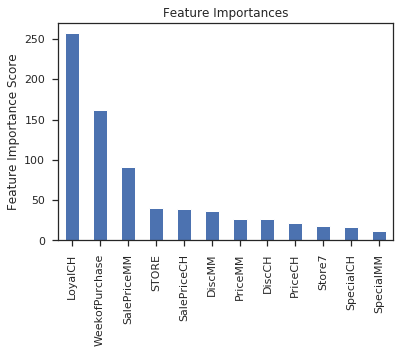

In [0]:

xgb1 = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                     objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(xgb1, X_train, Y_train,predictors,X_test, Y_test)

**Step 2: Tune max_depth and min_child_weight**

In [0]:
param_test1 = {
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=5000,
gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'max_depth': 1, 'min_child_weight': 4}, 0.872318120347647)

**Step 3: Tune gamma**

In [0]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=1,
 min_child_weight=4,subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, Y_train)
gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'gamma': 0.0}, 0.8952159968219426)

Here, we can see that the AUC on training data has decresead that might indicate that we might not be overfitting. However we see any improvement on our test set . So the final parameters are:

* max_depth: 1
* min_child_weight: 4
* gamma: 0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : (0.8368)
AUC Score (Train): 0.914133
AUC Score (Test): 0.877679


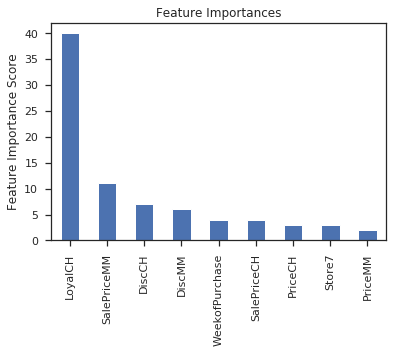

In [0]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=1,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=28)
modelfit(xgb2, X_train, Y_train,predictors,X_test, Y_test)

**Step 4: Tune subsample and colsample_bytree**

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=1,
 min_child_weight=4, gamma=0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'colsample_bytree': 0.6, 'subsample': 0.8}, 0.8938754840165359)

Here, we found colsample_bytree :0.6 and subsample to be 0.80. Now further zoning in by moving in steps of 5

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,80,5)],
 'colsample_bytree':[i/100.0 for i in range(50,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=1,
 min_child_weight=4, gamma=0, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, Y_train)
gsearch5.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'colsample_bytree': 0.6, 'subsample': 0.75}, 0.8938754840165359)

The optimum value therefore:
 * colsample_bytree : 0.60 
 * subsample : 0.75

**Step 5: Tuning Regularization Parameters**

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=1,
 min_child_weight=4, gamma=0.1, subsample=0.75, colsample_bytree=0.60,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, Y_train)
gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'reg_alpha': 1e-05}, 0.8956259879010441)

We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (1e-05) to see if we get something better.

In [0]:
param_test7 = {
 'reg_alpha':[1e-8,1e-7,1e-6, 1e-5, 1e-4]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=1,
 min_child_weight=4, gamma=0.1, subsample=0.75, colsample_bytree=0.60,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train, Y_train)
gsearch7.best_params_, gsearch7.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'reg_alpha': 1e-08}, 0.8956259879010441)

The reg_alpha or Lasso regularization actually does not play much of a role. This is understandable as our max tree depth is just 1 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : (0.8353)
AUC Score (Train): 0.915760
AUC Score (Test): 0.875471


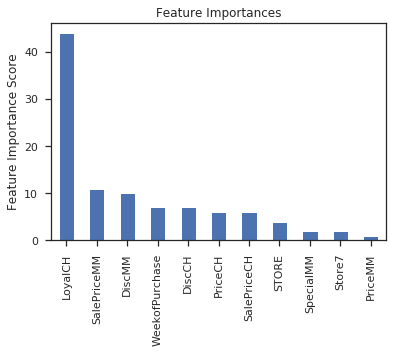

In [0]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=1,
 min_child_weight=4,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.60,
 reg_alpha=1e-8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train,Y_train, predictors, X_test, Y_test)

**Step 6: Reducing Learning Rate**

Lastly, I will try reducing the learning rate

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : (0.8518)
AUC Score (Train): 0.917239
AUC Score (Test): 0.887106


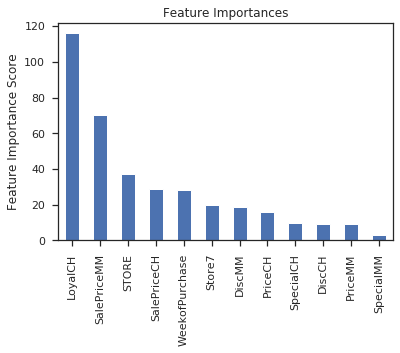

In [0]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.60,
 reg_alpha=1e-8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, X_train,Y_train, predictors, X_test,Y_test)